In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

## Predictors
- Nino3.4 DJF
- OLR Anomaly (West Pacific) DJF
- Soil Moisture Anomaly (Shallow) MAM
- Soil Moisture Anomaly (Deep) MAM
- Gulf SST Anomaly - Jan-May
- AMO - Jan-May
- PDO - Jan-May
- Prediction from Best Fit

In [2]:
X_2024 = [[1.738462, 2.1084975, -0.00337, -0.003494, 0.36, 0.65, -0.58, 108]]
X_2024 = [[1.738462, 2.1084975, -0.00337, -0.003494, -0.58, 108]]
X_2024_mlr_input = [[1.738462, 2.1084975, -0.00337, -0.003494, 0.36, 0.65, -0.58]]
X_2024_mlr_input = [[1.738462, 2.1084975, -0.00337, -0.003494, -0.58]]


In [3]:
df = pd.read_csv('./data/tx_heat_complete.csv', 
                 parse_dates=['year'], index_col='year')

In [4]:
# Best fit model
#plt.plot(np.unique(df.index.year), np.poly1d(np.polyfit(df.index.year, df['days_tmax_gt_100F'], 1))(np.unique(df.index.year)))
# Add predictions from best fit model to dataframe
df['best_fit'] = np.poly1d(np.polyfit(df.index.year, df['days_tmax_gt_100F'], 1))(df.index.year)

In [5]:
X = df.drop(columns=['t2m_max', 'days_tmax_gt_100F', 'sst_anomaly', 'amo'])

In [6]:
# Split the dataset into features and target variable
#X = df.drop(columns=['t2m_max', 'days_tmax_gt_100F'])
X_mlr = df.drop(columns=['t2m_max', 'days_tmax_gt_100F', 'best_fit', 'sst_anomaly', 'amo'])
y = df['days_tmax_gt_100F']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,
                                                    shuffle=False)

# Split the dataset into training and testing sets for the MLR model
X_train_mlr, X_test_mlr, y_train_mlr, y_test_mlr = train_test_split(
    X_mlr, y, test_size=0.25, random_state=42, shuffle=False)

# Split years into training and testing sets (for plotting ease of use)
years = X.index.year
X_train_years, X_test_years, y_train_years, y_test_years = train_test_split(years, y, test_size=0.25, random_state=42,
                                                    shuffle=False)
X_test_years = pd.to_datetime(X_test_years, format='%Y')

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scale the data for the MLR model
scaler_mlr = StandardScaler()
X_train_mlr = scaler_mlr.fit_transform(X_train_mlr)
X_test_mlr = scaler_mlr.transform(X_test_mlr)

# Scale the 2024 data
X_2024 = scaler.transform(X_2024)

# Scale the 2024 data for the MLR model
X_2024_mlr_input = scaler_mlr.transform(X_2024_mlr_input)

/Users/rhawthorne/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/rhawthorne/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Multiple Linear Regression Model

Linear Regression Training MAE: 31.18637633206038
Linear Regression Testing MAE: 44.68103888627704
Linear Regression Prediction: 91.57603833974767


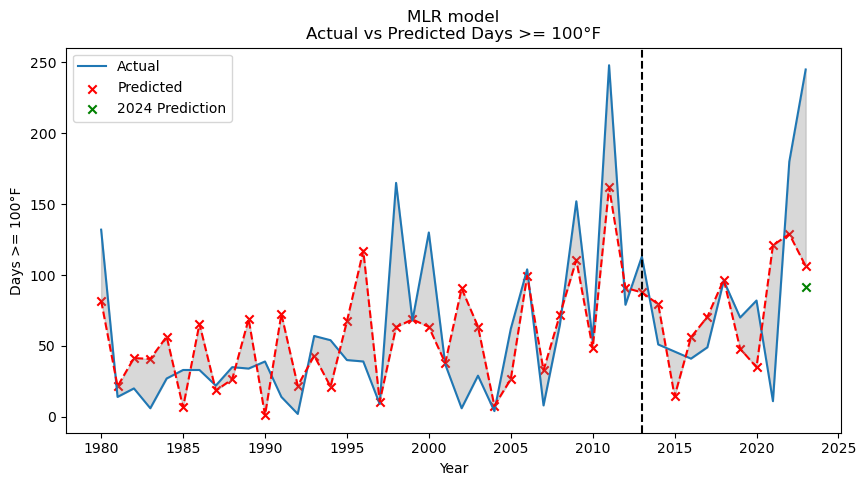

K-Nearest Neighbors Training MAE: 28.884848484848487
K-Nearest Neighbors Testing MAE: 45.872727272727275
K-Nearest Neighbors Prediction: 67.4


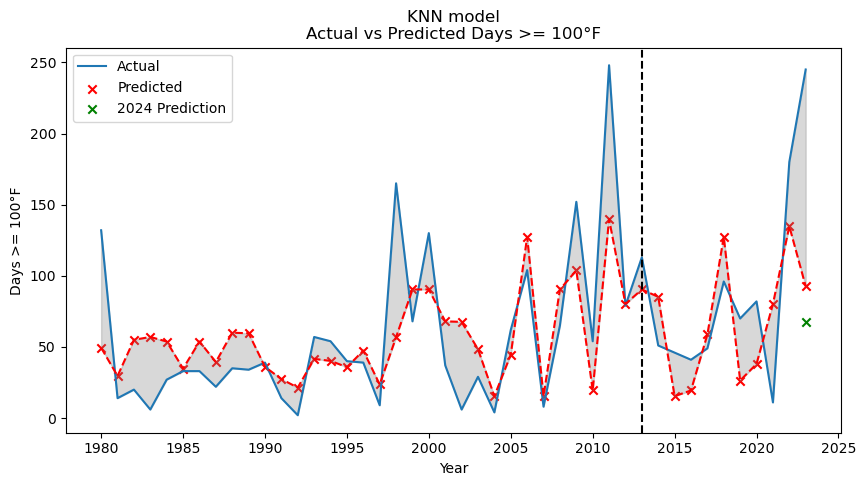

Random Forest Training MAE: 14.037272727272727
Random Forest Testing MAE: 41.74363636363636
Random Forest Prediction: 67.29333333333334


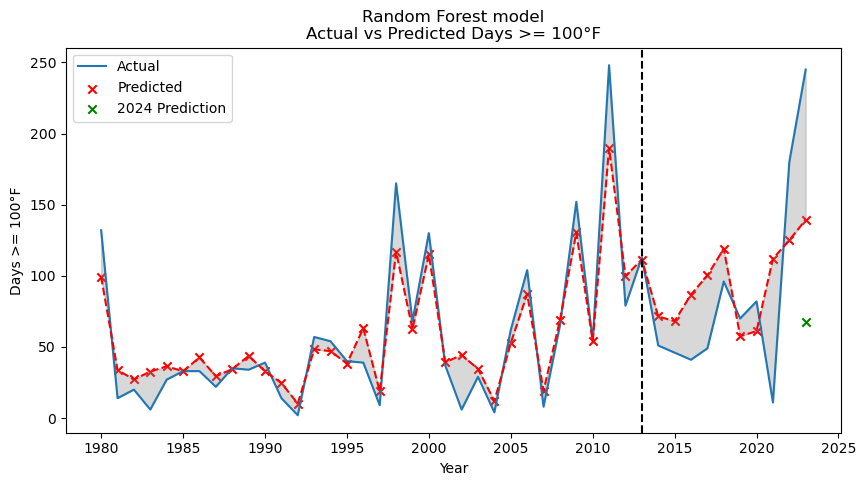

In [7]:
def mlr_model(X_train, y_train):
    """
    Accepts: training data
    Returns: a trained regression model
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def knn_model(X_train, y_train):
    """
    Accepts: training data
    Returns: a trained k-nearest neighbors model
    """
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def random_forest_model(X_train, y_train):
    """
    Accepts: training data
    Returns: a trained random forest model
    """

    # Use grid search to find the best hyperparameters
    param_grid = {'n_estimators': [100, 200, 300, 400, 500],
                 'max_features': [2, 4, 6, 8],
                 'criterion': ['squared_error', 'absolute_error'],
                 'ccp_alpha': [0, 0.5, 1, 10, 100]}
    grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
    # grid.fit(X_train, y_train)
    # print(grid.best_params_)

    model = RandomForestRegressor(max_features=4, n_estimators=300, random_state=42, 
                                  criterion='squared_error')
    model.fit(X_train, y_train)
    return model

def mae(model, X_train, X_test):
    """
    Accepts: a trained model
    Returns: the mean squared error of the training and testing sets
    """
    mae_train = mean_absolute_error(y_train, model.predict(X_train))
    mae_test = mean_absolute_error(y_test, model.predict(X_test))
    return mae_train, mae_test

def plot_predicted_vs_actual(type, model, X=X, X_test_years=X_test_years, 
                             X_2024=X_2024, scaler=scaler):
    """
    Accepts: a trained model
    Returns: a plot of the actual vs predicted values for the training and testing sets
    """
    # Plot year vs days_tmax_gt_100F for training and testing sets as a scatter plot
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['days_tmax_gt_100F'], label='Actual')
    plt.scatter(df.index, model.predict(scaler.transform(X)), label='Predicted', c='r', marker='x')

    # Plot prediction for 2024 at the end of the graph
    plt.scatter(X_test_years[-1], model.predict(X_2024), c='g', marker='x', label='2024 Prediction')

    # Create a line between the actual and predicted values
    plt.plot(df.index, model.predict(scaler.transform(X)), c='r', linestyle='--')

    # Shade the area between the actual and predicted values
    plt.fill_between(df.index, df['days_tmax_gt_100F'], 
                     model.predict(scaler.transform(X)).reshape(-1), 
                     color='gray', alpha=0.3)
    
    # Draw vertical line to delineate boundary between training and testing sets
    plt.axvline(x=X_test_years[0], c='k', linestyle='--')

    plt.title(f'{type} model\nActual vs Predicted Days >= 100°F')
    plt.xlabel('Year')
    plt.ylabel('Days >= 100°F')
    plt.legend()
    plt.show()

def prediction(model, X_year_of_interest):
    """
    Accepts: a trained model and the features for the year of interest
    Returns: the predicted number of days >= 100°F in 2024
    """
    return model.predict(X_year_of_interest)

lin_reg = mlr_model(X_train_mlr, y_train_mlr)
mae_train, mae_test = mae(lin_reg, X_train_mlr, X_test_mlr)
print(f"Linear Regression Training MAE: {mae_train}")
print(f"Linear Regression Testing MAE: {mae_test}")
print(f"Linear Regression Prediction: {prediction(lin_reg, X_2024_mlr_input)[0]}")
plot_predicted_vs_actual('MLR', lin_reg, X_mlr, X_test_years, X_2024_mlr_input, scaler_mlr)

knn_reg = knn_model(X_train, y_train)
mae_train, mae_test = mae(knn_reg, X_train, X_test)
print(f"K-Nearest Neighbors Training MAE: {mae_train}")
print(f"K-Nearest Neighbors Testing MAE: {mae_test}")
print(f"K-Nearest Neighbors Prediction: {prediction(knn_reg, X_2024)[0]}")
plot_predicted_vs_actual('KNN', knn_reg)

rf_reg = random_forest_model(X_train, y_train)
mae_train, mae_test = mae(rf_reg, X_train, X_test)
print(f"Random Forest Training MAE: {mae_train}")
print(f"Random Forest Testing MAE: {mae_test}")
print(f"Random Forest Prediction: {prediction(rf_reg, X_2024)[0]}")
plot_predicted_vs_actual('Random Forest', rf_reg)

# Neural Nets

In [8]:
def dnn_model(X_train, y_train):
    """
    Accepts: training data
    Returns: a trained DNN model
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=500, monitor='val_loss',
                                                        mode='min', restore_best_weights=True)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint('cp.ckpt', 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=0)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(3, activation='relu', input_shape=(6,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(X_train, y_train, epochs=3000, verbose=1,
              callbacks=[early_stopping],
              validation_data=(X_test, y_test))
    return model

def dnn_model_single_layer(X_train, y_train):
    """
    Accepts: training data
    Returns: a trained DNN model
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=500, monitor='val_loss',
                                                        mode='min', restore_best_weights=True)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint('cp.ckpt', 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=0)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(13, activation='relu', input_shape=(6,)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='huber', metrics=['mae'])
    model.fit(X_train, y_train, epochs=3000, verbose=1,
              callbacks=[early_stopping],
              validation_data=(X_test, y_test))
    return model

def lstm_model(X_train, y_train):
    """
    Accepts: training data
    Returns: a trained LSTM model
    """
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=500, monitor='val_loss',
                                                        mode='min', restore_best_weights=True)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint('cp.ckpt', 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=0)
    
    # Reshape the data for the LSTM model
    X_train = X_train.reshape(-1, 7, 1)

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(7, 1)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=3000, verbose=1,
              callbacks=[early_stopping],
              validation_data=(X_test, y_test))
    return model

small_dnn = dnn_model(X_train, y_train)
#lstm = lstm_model(X_train, y_train)
#single_layer = dnn_model_single_layer(X_train, y_train)

Epoch 1/3000
2/2 [==============================] - 0s 71ms/step - loss: 6036.8325 - mae: 55.0892 - val_loss: 12342.2100 - val_mae: 89.7788
Epoch 2/3000
2/2 [==============================] - 0s 12ms/step - loss: 6035.2402 - mae: 55.0772 - val_loss: 12338.5059 - val_mae: 89.7630
Epoch 3/3000
2/2 [==============================] - 0s 11ms/step - loss: 6033.7656 - mae: 55.0661 - val_loss: 12334.9180 - val_mae: 89.7477
Epoch 4/3000
2/2 [==============================] - 0s 12ms/step - loss: 6032.3716 - mae: 55.0555 - val_loss: 12331.6152 - val_mae: 89.7336
Epoch 5/3000
2/2 [==============================] - 0s 12ms/step - loss: 6031.0605 - mae: 55.0456 - val_loss: 12328.4004 - val_mae: 89.7200
Epoch 6/3000
2/2 [==============================] - 0s 11ms/step - loss: 6029.8062 - mae: 55.0360 - val_loss: 12325.1816 - val_mae: 89.7063
Epoch 7/3000
2/2 [==============================] - 0s 11ms/step - loss: 6028.4365 - mae: 55.0261 - val_loss: 12322.0898 - val_mae: 89.6931
Epoch 8/3000
2/2 [==

1/1 [==============================] - 0s 8ms/step
DNN Training MAE: 29.358702457312383
DNN Testing MAE: 36.98582926663485
1/1 [==============================] - 0s 8ms/step
DNN Prediction: [84.184]
2/2 [==============================] - 0s 771us/step


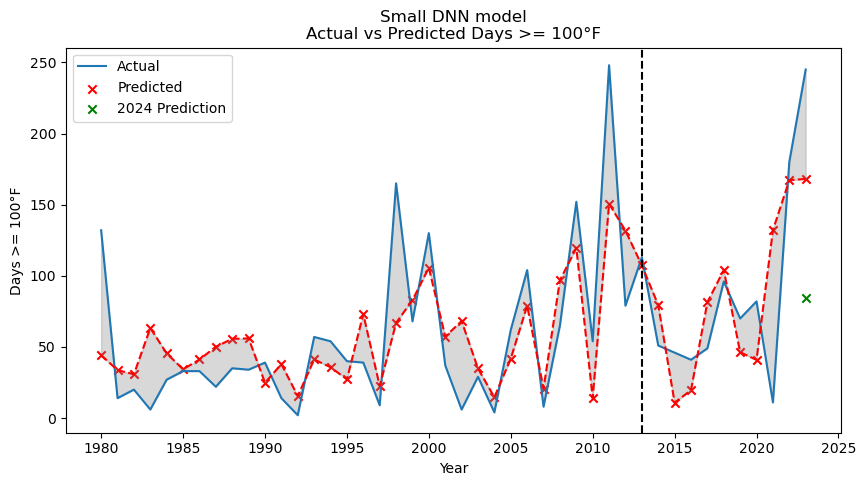

In [9]:
# Calculate the mean absolute error for the DNN model
mae_train, mae_test = mae(small_dnn, X_train, X_test)
print(f"DNN Training MAE: {mae_train}")
print(f"DNN Testing MAE: {mae_test}")

print(f"DNN Prediction: {prediction(small_dnn, X_2024)[0]}")

plot_predicted_vs_actual('Small DNN', small_dnn)

# XGBoost Model

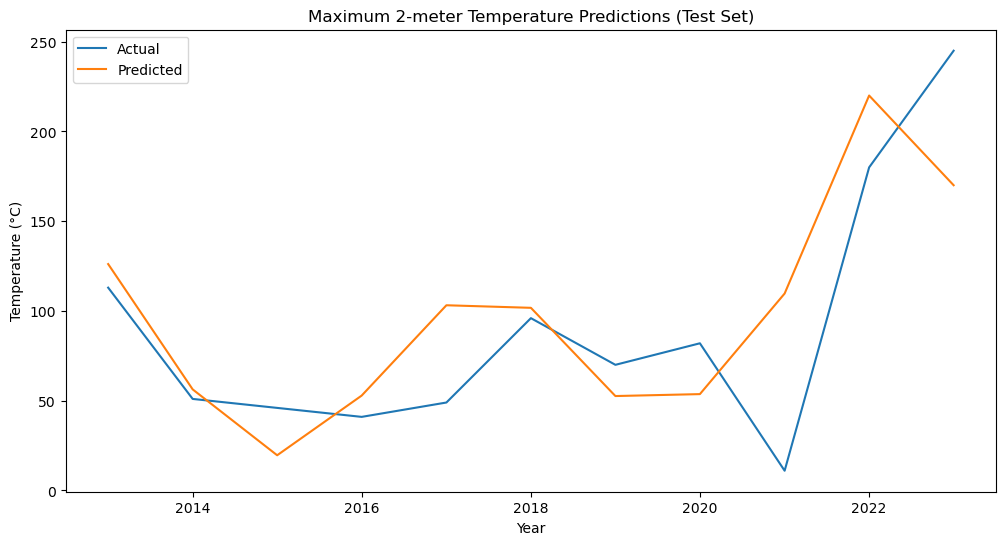

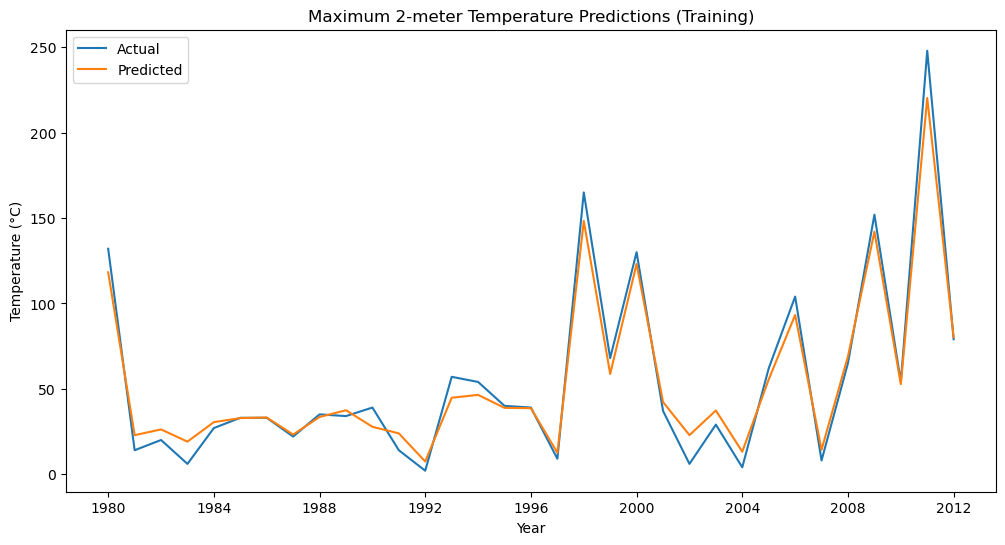

Mean Absolute Error for training data: 7.369785265489058
Mean Absolute Error for test data: 34.18713188171387


In [10]:
def find_best_params(X_train, y_train):
    # Create the parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 4, 5],
        'n_estimators': [75, 100, 200, 300, 400]
    }

    # Instantiate the regressor
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

    # Instantiate the GridSearchCV object
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and lowest RMSE
    print(f"Best parameters found: {grid_search.best_params_}")

    return grid_search.best_params_

#best_params = find_best_params(X_train, y_train)

# Train the model
xg_reg = xgb.XGBRegressor(learning_rate = 0.01,
                          max_depth = 4, n_estimators = 400)
xg_reg.fit(X_train, y_train)

# Predict the model
y_pred = xg_reg.predict(X_test)

# Graph test vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Maximum 2-meter Temperature Predictions (Test Set)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.show()

# Plot training prediction vs actual
y_train_pred = xg_reg.predict(X_train)

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Actual')
plt.plot(y_train.index, y_train_pred, label='Predicted')
plt.title('Maximum 2-meter Temperature Predictions (Training)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Print training and testing MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"Mean Absolute Error for training data: {mae_train}")

mae_test = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error for test data: {mae_test}")


In [11]:
y_2024 = xg_reg.predict(X_2024)
print(f"Predicted number of days with a maximum temperature greater than 100°F in 2024: {y_2024[0]:.2f}")

Predicted number of days with a maximum temperature greater than 100°F in 2024: 56.62
